<a href="https://colab.research.google.com/github/MichaelKasper1/Natural_Language_Processing/blob/main/Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification Using Natural Language Processing

Natural language processing (NLP) is a large subfield of machine learning. NLP allows data to be extracted from text. This can be implemented to perform tasks such as creating translators, performing sentiment analysis to understand product reviews on large scale, or help guide medical diagnostics.

In this project, I will be performing sentiment analysis on data from tensorflow's downloadable data sets. Specifically, I will be using Tensorflow's yelp_polarity_review dataset. I will be talking about sentiment analysis in this notebook, but these models could also be used to extract other kinds of important text data.

If I had more time and unlimited computing power, I would try many models and tune parameters for each. Ideally, I would keep embedding and modeling methods consistent so I could compare accuracy of my models only changing one variable at a time. This project is more about personal learning than anything else so I did not worry about that.

### Model 1: GloVe Embedding and Convolutional Neural Network

This will be done utilizing a Convolutional Neural Network to predict if the reviews in the data sets are positive or negative.

Words are embedded using GloVe (global vectors for word representation). This type of embedding focuses on words co occurances over the whole corpus. I could have also used Word2Vec for word embedding which is a shallow neural network that learns word associations.

If you are like me and have an old computer with a crappy processor, I highly recommend using google colab to run this notebook. Since it will run on a hosted computer, the training for the CNN will go much faster. Even better, switch your runtime to GPU! This made my code run over 10x faster.

### Model 2: Emedding with TfidfVectorizer and Modeling with Stoichastic Gradient Descent

### Importing Necessary Libraries

In [7]:
# I had some issues importing modules that were needed for this analysis into google colab. 
# I ended up using this method to get them into the notebook manually from my local CPU.
from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving utils.py to utils (1).py


In [8]:
getLocalFiles()

Saving cnn_model.py to cnn_model (1).py


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from utils import clean_doc
from utils import char_vectorizer
from cnn_model import CNN
from sklearn.model_selection import train_test_split
from utils import create_glove_embeddings

### Defining Aphabet and Maximum Review Length

In [10]:
max_number_words  = 15000
max_sequence_length = 200
alphabet = " abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
alphabet_size = len(alphabet)
dataset = 'yelp_polarity_reviews'

If you want to use this notebook to perform analysis at the character level instead of at the word level then change this parameter to True.

In [11]:
use_char = False

### Loading and Splitting Data

In [12]:

# Load train dataset
train = tfds.as_numpy(tfds.load(dataset, data_dir=f"data/{dataset}", split="train", batch_size=-1))
X_train, y_train = [clean_doc(x.decode()) for x in train["text"]], train["label"]

# Load test dataset
test = tfds.as_numpy(tfds.load(dataset, data_dir=f"data/{dataset}", split="test", batch_size=-1))
X_test, y_test = [clean_doc(x.decode()) for x in test["text"]], test["label"]

print(f"Train samples: {len(X_train)}")
print(f"Test samples:  {len(X_test)}")

Train samples: 560000
Test samples:  38000


In [13]:
# Below is the training data. I always like to get a visualization for what the data actually looks like. 
# In this case, it is just strings from reviews just as expected!
X_train

["the groovy p. and i ventured to his old stomping grounds for lunch today. the '5 and diner' on 16th st and colter left me with little to ask for. before coming here i had a preconceived notion that 5 & diners were dirty and nasty. not the case at all.\\n\\nwe walk in and let the waitress know we want to sit outside (since it's so nice and they had misters). we get two different servers bringing us stuff (talk about service) and i ask the one waitress for recommendations. i didn't listen to her, of course, and ordered the southwestern burger w/ coleslaw and started with a nice stack of rings.\\n\\nthe onion rings were perfectly cooked. they looked like they were prepackaged, but they were very crispy and i could actually bite through the onion without pulling the entire thing out (don't you hate that?!!!)\\n\\nthe southwestern burger was order medium rare and was cooked accordingly. soft, juicy, and pink with a nice crispy browned outer layer that can only be achieved on a well used g

### Preprocessing for word-based model

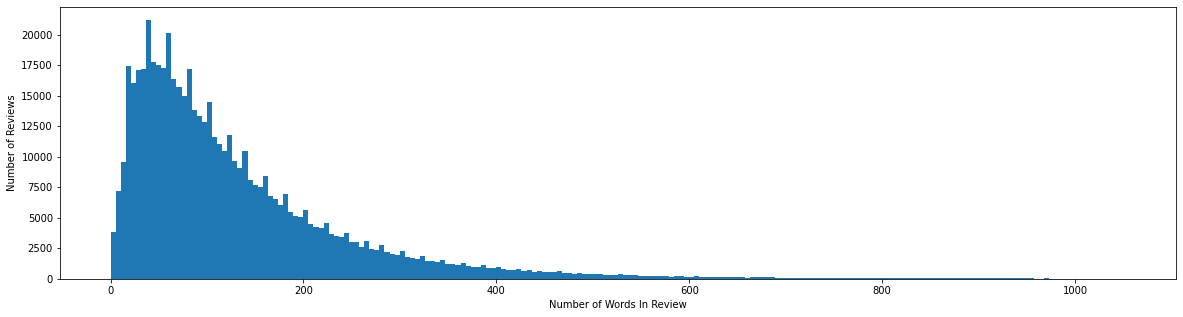

Text informations:
 - max length: 1052
 - min length: 1
 - mean length: 133.0288732142857
 - limit length: 200


In [16]:
# Using tokenizer from keras, each review will be tokenized based on number of words.
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_number_words)
tokenizer.fit_on_texts(X_train)
sequences  = tokenizer.texts_to_sequences(X_train)
word_index = tokenizer.word_index
result     = [len(x.split()) for x in X_train]

# Plot histogram to show distribution of number of words within each review
plt.figure(figsize=(20,5))
plt.xlabel("Number of Words In Review")
plt.ylabel("Number of Reviews")
plt.hist(result, 200, density=False, range=(0,np.max(result)))
plt.show()

#Printing results of the lengths to help get a better understanding of the dataset.
print("Text informations:")
print(f" - max length: {np.max(result)}")
print(f" - min length: {np.min(result)}")
print(f" - mean length: {np.mean(result)}")
print(f" - limit length: {max_sequence_length}")

# Padding all sequences to the length of the maximum sequence
word_data = tf.keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen  = max_sequence_length,
    padding = 'post')

*Observations*
- There distribution is very much right skewed.
- None of the training data was close to the maximum that was set.

### Preprocessing for char-based model

In [17]:
if use_char:
    char2idx_dict = {}
    idx2char_dict = {}

    for idx, char in enumerate(alphabet):
        char2idx_dict[char] = idx + 1

    idx2char_dict = dict([(i+1, char) for i, char in enumerate(char2idx_dict)])
    
    # Get information about char sequence length
    result = [len(x) for x in X_train]
    plt.figure(figsize=(20,5))
    plt.title("Char length")
    plt.hist(result, 200, density=False, range=(0,np.max(result)))
    plt.show()
    
    print("Text informations:")
    print(f" - max:   {np.max(result)}")
    print(f" - min:   {np.min(result)}")
    print(f" - mean:  {np.mean(result)}")
    print(f" - limit: {char_max_length}")
    
    char_data = char_vectorizer(X_train, char_max_length, char2idx_dict)

### Parameters for CNN Training

In [24]:
#parameters to train the CNN
# The reason I define my parameters here instead of within the model is so there is easy access to tuning.
dropout_rate = 0.5
hidden_units = 250
nb_classes   = 2
batch_size = 100
number_epochs  = 5
runs = 5
validation_size = 0.2
char_embedding_dimension = 300
char_max_length = 2500
char_kernel_sizes = [5,10,20]
char_feature_maps = [200,200,200]
embedding_dimensions  = 300
use_glove = True 
# GloVe Embeddings are a type of word embedding that encode the co-occurrence probability ratio between two words as vector differences.
kernel_sizes = [3,4,5]
feature_maps = [200,200,200]

### Training

In [25]:
histories = []

for i in range(runs):
    print(f"Running iteration {i+1}/{runs}")
    random_state = np.random.randint(1000)
    
    _X_train, _X_val, _y_train, _y_val = train_test_split(
        word_data, 
        tf.keras.utils.to_categorical(y_train),
        test_size = validation_size, 
        random_state = random_state
    )
    
    if use_char:
        _X_train_c, _X_val_c, _, _ = train_test_split(
            char_data,
            tf.keras.utils.to_categorical(y_train),
            test_size = validation_size,
            random_state = random_state
        )
        
        _X_train = [_X_train, _X_train_c]
        _X_val   = [_X_val,   _X_val_c]
    
    
    emb_layer = None
    if use_glove:
        emb_layer = create_glove_embeddings(
            embedding_dim  = embedding_dimensions,
            max_num_words  = max_number_words,
            max_seq_length = max_sequence_length,
            tokenizer      = tokenizer
        )
    
    model = CNN(
        embedding_layer    = emb_layer,
        num_words          = max_number_words,
        embedding_dim      = embedding_dimensions,
        kernel_sizes       = kernel_sizes,
        feature_maps       = feature_maps,
        max_seq_length     = max_sequence_length,
        use_char           = use_char,
        char_embedding_dim = char_embedding_dimension,
        char_max_length    = char_max_length,
        alphabet_size      = alphabet_size,
        char_kernel_sizes  = char_kernel_sizes,
        char_feature_maps  = char_feature_maps,
        dropout_rate       = dropout_rate,
        hidden_units       = hidden_units,
        nb_classes         = nb_classes
    ).build_model()
    
    model.compile(
        loss      = "categorical_crossentropy",
        optimizer = tf.optimizers.Adam(),
        metrics   = ["accuracy"]
    )
    
    history = model.fit(
        _X_train, _y_train,
        epochs          = number_epochs,
        batch_size      = batch_size,
        validation_data = (_X_val, _y_val),
        callbacks       = [tf.keras.callbacks.ModelCheckpoint(
            filepath       = f"model-{i+1}.h5",
            monitor        = "val_loss",
            verbose        = 1,
            save_best_only = True,
            mode           = "min"
        )]
    )

    histories.append(history.history)

Running iteration 1/5
Pretrained GloVe embedding is loading...
Found 400000 word vectors in GloVe embedding

Epoch 1/5
4480/4480 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.9239
Epoch 1: val_loss improved from inf to 0.12938, saving model to model-1.h5
4480/4480 [==============================] - 379s 84ms/step - loss: 0.1871 - accuracy: 0.9239 - val_loss: 0.1294 - val_accuracy: 0.9494
Epoch 2/5
4480/4480 [==============================] - ETA: 0s - loss: 0.1337 - accuracy: 0.9485
Epoch 2: val_loss improved from 0.12938 to 0.12039, saving model to model-1.h5
4480/4480 [==============================] - 354s 79ms/step - loss: 0.1337 - accuracy: 0.9485 - val_loss: 0.1204 - val_accuracy: 0.9538
Epoch 3/5
4480/4480 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.9556
Epoch 3: val_loss improved from 0.12039 to 0.11853, saving model to model-1.h5
4480/4480 [==============================] - 373s 83ms/step - loss: 0.1179 - accuracy: 0.9556 -

### Evaluating Accuracy and Loss of the Average Iteration of the Model


In [26]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)

print(f"Training: \t{get_avg(histories,'loss')} loss / {get_avg(histories,'accuracy')} acc")
print(f"Validation: \t{get_avg(histories,'val_loss')} loss / {get_avg(histories,'val_accuracy')} acc")

Training: 	0.10849205255508423 loss / 0.9592607140541076 acc
Validation: 	0.11617816090583802 loss / 0.956019651889801 acc


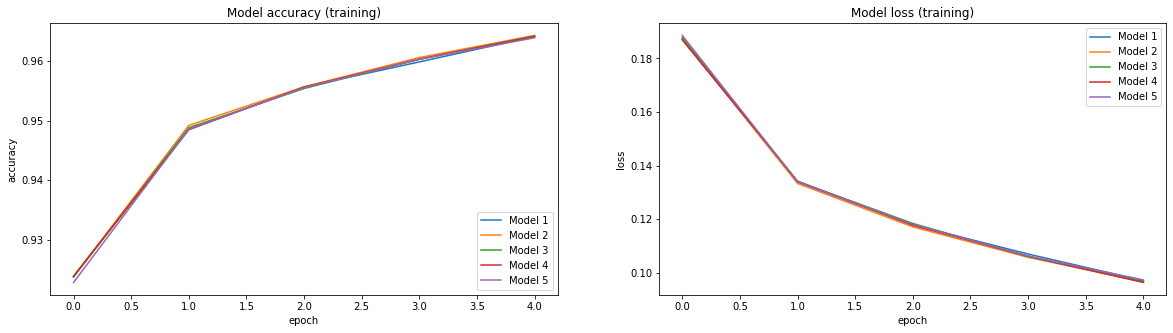

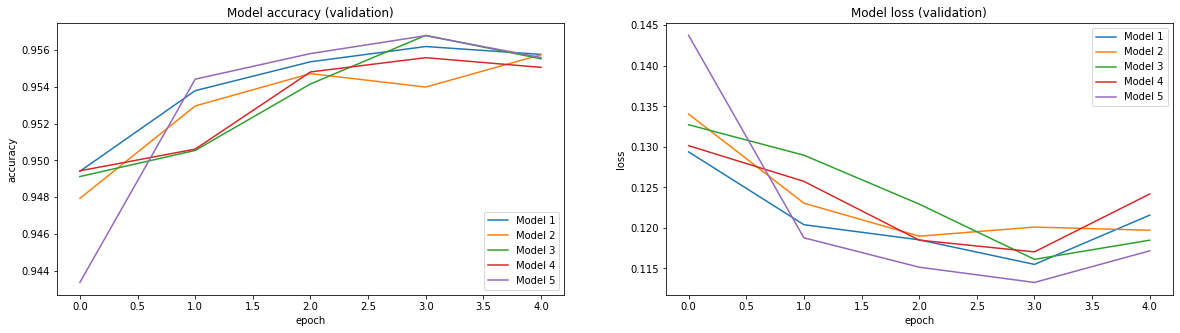

In [27]:
from utils import plot_acc_loss
plot_acc_loss('training', histories, 'accuracy', 'loss')
plot_acc_loss('validation', histories, 'val_accuracy', 'val_loss')

___________________
# Model 2!


#### Defining Embedding Method: Use TfidfVectorizer

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(
    ngram_range  = (1,2),
    min_df       = 0.0005,
    max_df       = 0.1,
    lowercase    = False,
    preprocessor = None,
    sublinear_tf = True,
    use_idf      = True,
)

#### Define Model : Stoichastic Gradient Descent

In [29]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(
    max_iter            = 1000,
    tol                 = 1e-3,
    validation_fraction = 0.2
)

#### Define Pipeline

In [30]:
from sklearn.pipeline import Pipeline

ml_classifier = Pipeline([
    ('vectorizer', tf_idf),
    ('classifier', sgd)
])

#### Train Classifier

In [31]:
_X_train, _X_val, _y_train, _y_val = train_test_split(X_train, y_train, test_size= validation_size)
ml_classifier.fit(_X_train, _y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, max_df=0.1, min_df=0.0005,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('classifier', SGDClassifier(validation_fraction=0.2))])

In [32]:
val_pred = ml_classifier.predict(_X_val)
print(f"Accuracy: {np.mean(_y_val==val_pred)}")

Accuracy: 0.9384285714285714


#### Inspect Important features for Senitment Analysis by Extracting the Coefficients

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Extracted features: 36166


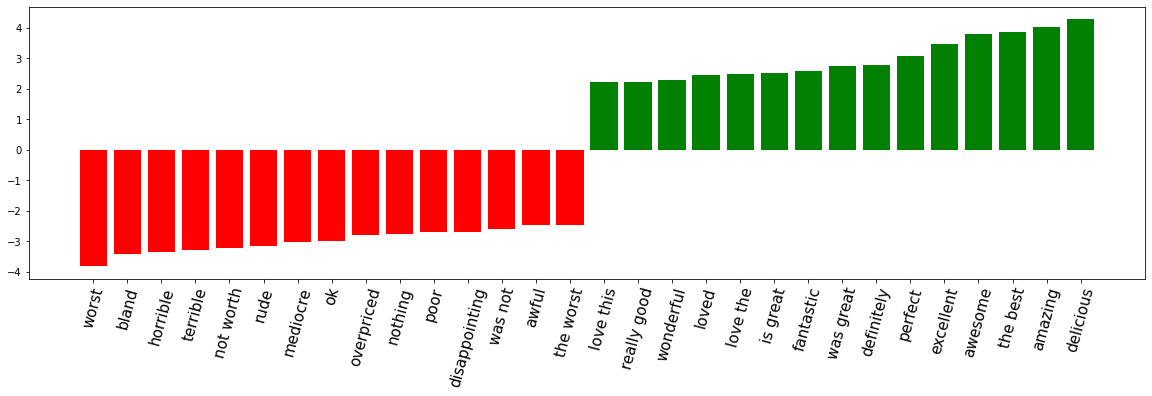

In [33]:
from utils import visualize_features

visualize_features(ml_classifier)

#### Final evaluation

In [34]:
preds = ml_classifier.predict(X_test)
print(f"Accuracy: {np.mean(y_test==preds)}")

Accuracy: 0.9402105263157895


The accuracy of the second model is about 0.01 lower than the accuracy from the first model utilizing CNNs. However, the runtime of the second model was significantly lower than the first. In response, I would recommend using the second model over the first unless you have an abundance of computing power and time and the only important metric is accuracy of the model.

# Model 3!

### Define Transformer: BERT

In [ ]:
# Not completed yet, but this is on its way soon!

### Define Model (The same model as model 2 just with different embedding method)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(
    max_iter            = 1000,
    tol                 = 1e-3,
    validation_fraction = 0.2
)

### References

The analysis with the CNN follows work from a paper written by Yoon Kim. It is a simplified version of her paper and unlike hers, it utilizes tensorflow. Her work can be found here. A similiar analysis was performed by Denny Britz.:

https://github.com/yoonkim/CNN_sentence
https://github.com/dennybritz/cnn-text-classification-tf


Analysis with BERT will be preformed with the help of tensorflow's tutorial:
https://www.tensorflow.org/text/tutorials/classify_text_with_bert


